- Student name: Duy Hieu Nguyen
- SID: 33694052

# 3. **Unsupervised Learning**

## Question 3. Self-supervised Neural Network Learning

### Task 1:  Load data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

labeled_data = pd.read_csv('Task2C_labeled.csv')
unlabeled_data = pd.read_csv('Task2C_unlabeled.csv')
test_data = pd.read_csv('Task2C_test.csv')

In [2]:
def show_images(images, labels = None, size=(28,28), rows = 1, scale=4):
    assert((labels is None)or (len(images) == len(labels)))
    n_images = len(images)
    if labels is None: 
        labels = ['Image (%d)' % i for i in range(1,n_images + 1)]
    else:
        labels = ['Label: (%d)' % i for i in labels]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, labels)):
        image = image.reshape(size)
        cols = int(np.ceil(n_images / float(rows)))
        a = fig.add_subplot(rows,cols,n+1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images/scale)
    plt.show()

Visualize some sample of label, unlabel and test data

Labeled Data


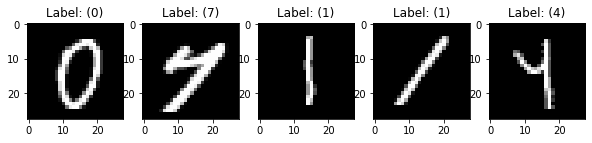

Unlabeled Data


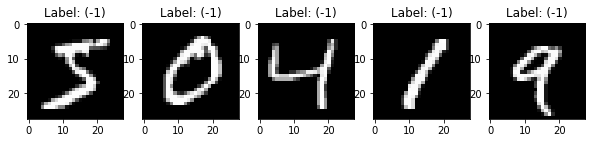

Test Data


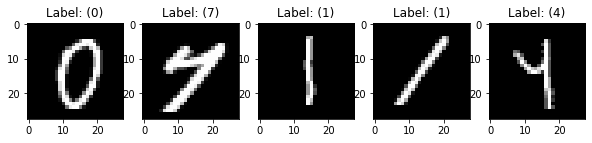

In [3]:
print("Labeled Data")
X_labeled = np.array(labeled_data.iloc[:,1:])
Y_labeled = np.array(labeled_data.iloc[:,0])
show_images(X_labeled[:5], Y_labeled[:5],rows=1, scale=3)

print("Unlabeled Data")
unlabeled_data.insert(0, 'label', -1)
X_unlabeled = np.array(unlabeled_data.iloc[:,1:])
Y_unlabeled = np.array(unlabeled_data.iloc[:,0])
show_images(X_unlabeled[:5], Y_unlabeled[:5],rows=1, scale=3)
unlabeled_data = unlabeled_data.drop(columns=['label'])

print("Test Data")
X_test = np.array(test_data.iloc[:,1:])
Y_test = np.array(test_data.iloc[:,0])
show_images(X_labeled[:5], Y_labeled[:5],rows=1, scale=3)

### Task 2: Auto Encorder Implement


In [4]:
# Combinning labeled and unlabeled data to train AE
X_train = np.vstack((X_labeled, X_unlabeled))

reconstruction_errors = []
neurons_range = list(range(20, 221, 40))

for neurons in neurons_range:
    # Train the autoencoder
    autoencoder = MLPRegressor(hidden_layer_sizes=(neurons,), activation='relu', max_iter=70, random_state=0)
    autoencoder.fit(X_train, X_train)
    
    # Reconstruct the input data
    X_pred = autoencoder.predict(X_train)
    
    # Calculate the average Euclidean distance as the reconstruction error
    error = np.mean(np.sqrt(np.sum((X_train - X_pred)**2, axis=1)))
    reconstruction_errors.append(error)


C:\Users\chuth\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\chuth\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\chuth\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\chuth\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\chuth\anaconda3\lib\site-packages\sklearn\neural_network\_multilaye

### Task 3: Plotting reconstruction error of AE

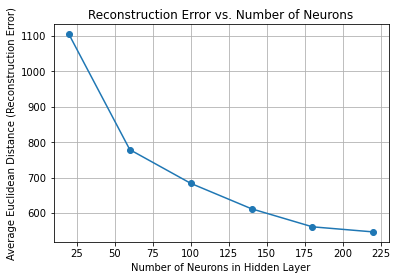

In [5]:
# Plotting
plt.plot(neurons_range, reconstruction_errors, marker='o', linestyle='-')
plt.xlabel('Number of Neurons in Hidden Layer')
plt.ylabel('Average Euclidean Distance (Reconstruction Error)')
plt.title('Reconstruction Error vs. Number of Neurons')
plt.grid(True)
plt.show()

#### **Observation**:
From the graph, we can see that the higher the number of nodes in hidden layers, the smaller the test error, which starts from 1100 and decreases significantly to around 550.
#### **Explanation** 
- AutoEncoder try to compress the original image data into a more compact form. In this case, it try to 'zip' 784 'pixels' into K 'pixels' as the number of neurons in hidden layer.
- If we have only a few neurons in the hidden layer, there's limited capacity to hold all the information from the original images. This leads to more loss of detail and higher error when reconstructing the images.
- As the number of neurons in hidden layer increases, autoencoder has more space to store important details from the images. This means it can capture the patterns better, reconstruct the images with more accuracy, leading to a lower error.

### Task 4: Regular Neuron Network implement


In [6]:
# Loop over all combinations of K and learning rate
test_errors = []
neurons_range = list(range(20, 221, 40))

for neurons in neurons_range:
    # Initialize and train the MLPClassifier
    clf = MLPClassifier(hidden_layer_sizes=(neurons,), max_iter=1000, random_state=0)
    clf.fit(X_labeled, Y_labeled)
    
    # Predict on the test set
    y_pred = clf.predict(X_test)
    
    # Calculate test error = (1 - accuracy)
    error = 1 - accuracy_score(Y_test, y_pred)
    # Record test error
    test_errors.append(error)

### Task 5: Self-taught Neuron Network implement


This function take the mid layer output of autoencoder

In [7]:
# Extract feature from hidden layer
def extract_features(autoencoder, X):
    for layer in autoencoder.coefs_[:len(autoencoder.coefs_)//2]:
        X = np.dot(X, layer)  # Weighted sum
        X = np.maximum(X, 0)  # ReLU activation
    return X
print(len(autoencoder.coefs_))

2


NN + AE Implement

In [8]:
# Storage for test errors of self-taught networks
self_taught_test_errors = []

for neurons in neurons_range:
    # Train the autoencoder
    autoencoder = MLPRegressor(hidden_layer_sizes=(neurons,), activation='relu', max_iter=70 , random_state=0)
    autoencoder.fit(X_labeled, X_labeled)

    # Extract features from the middle layer of autoencoder
    autoencoder_features = extract_features(autoencoder, X_labeled)

    # Augment original features with autoencoder's features
    X_augmented = np.hstack((X_labeled, autoencoder_features))

    # Train a new 3-layer neural network on the augmented features 784 + neurons in hidden
    clf = MLPClassifier(hidden_layer_sizes=(neurons,), max_iter=1000, random_state=0)
    clf.fit(X_augmented, Y_labeled)  

    # Predict on the test set (augment the test set with autoencoder features)
    X_test_augmented = np.hstack((X_test, extract_features(autoencoder, X_test)))
    y_pred = clf.predict(X_test_augmented)

    # Calculate test error = (1 - accuracy)
    error = 1 - accuracy_score(Y_test, y_pred)
    # Record test error
    self_taught_test_errors.append(error)

C:\Users\chuth\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\chuth\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\chuth\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\chuth\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\chuth\anaconda3\lib\site-packages\sklearn\neural_network\_multilaye

### Task 6: Plotting error of NNs 

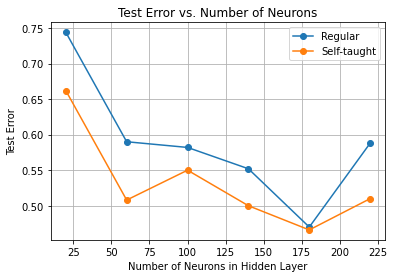

In [9]:
plt.plot(neurons_range, test_errors, marker='o', label = "Regular", linestyle='-')
plt.plot(neurons_range, self_taught_test_errors, label = "Self-taught", marker='o', linestyle='-')
plt.xlabel('Number of Neurons in Hidden Layer')
plt.ylabel('Test Error')
plt.title('Test Error vs. Number of Neurons')
plt.legend()  # This will place the legend in the upper right corner
plt.grid(True)
plt.show()

In [10]:
print(test_errors)
print(self_taught_test_errors)

[0.744, 0.5900000000000001, 0.5820000000000001, 0.552, 0.47, 0.5880000000000001]
[0.6619999999999999, 0.508, 0.55, 0.5, 0.46599999999999997, 0.51]


#### **Discussion**:

**Observation**:
- Both the regular Neural Network and the self-taught NN show a general decrease in test error as the number of neurons increases, with the lowest errors are approximately 0.45 at 180 neurons for both. After this point, both models experience a slight uptick in test error when moving from 180 to 220 neurons.
- It is also noticable that across different neuron counts, the **self-taught NN tends to outperform the regular NN**, achieving a lower test error (for instance, at 60 neurons, the test error of regular and seld-taught NN are 0.60 and 0.50, respectively).

**Explanation**:
- **Benefit of Encoded Features**: The self-taught NN contains features extracted by the autoencoder. This added information encapsulates essential patterns found in the handwritten digits, making the network in better distinguishing between them. As the encoding's dimensionality increases (with more neurons), the quality of these features generally improves, offering better classification performance.
- **Overfitting Concern**: As the number of neurons increases, both models gain the ability to capture more intricate patterns in the MNIST data, leading to a decrease in test error. However, the slight increase in test error for both networks from 180 to 220 neurons might hint at overfitting. As we increase the network's complexity, it might start to "memorize" the training data including noise rather than learning general patterns, which then leads to bad performance on unseen test data.